In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import regularizers,backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
from PIL import Image, ImageFilter

sns.set_style('darkgrid')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/DATA"

'Batik Ceplok'	   'Batik Kawung'  'Batik Pamiluto'	 'Batik Semen'	    'Batik Slobog'
'Batik Ciptoning'  'Batik Nitik'   'Batik Parang Rusak'  'Batik Sidomukti'  'Batik Wahyu Tumurun'


In [4]:
sdir=r'/content/drive/My Drive/DATA'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head(5))
print (df['labels'].value_counts())

                                           filepaths        labels
0  /content/drive/My Drive/DATA/Batik Kawung/kawu...  Batik Kawung
1  /content/drive/My Drive/DATA/Batik Kawung/moti...  Batik Kawung
2  /content/drive/My Drive/DATA/Batik Kawung/kawu...  Batik Kawung
3  /content/drive/My Drive/DATA/Batik Kawung/moti...  Batik Kawung
4  /content/drive/My Drive/DATA/Batik Kawung/moti...  Batik Kawung
labels
Batik Kawung           200
Batik Slobog           200
Batik Ceplok           200
Batik Ciptoning        200
Batik Pamiluto         200
Batik Semen            200
Batik Sidomukti        200
Batik Parang Rusak     200
Batik Wahyu Tumurun    200
Batik Nitik            200
Name: count, dtype: int64


In [5]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1600   test_df length:  200   valid_df length:  200


In [6]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

# Data Augmenation
gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  50   test steps:  4
Found 1600 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
['Batik Ceplok', 'Batik Ciptoning', 'Batik Kawung', 'Batik Nitik', 'Batik Pamiluto', 'Batik Parang Rusak', 'Batik Semen', 'Batik Sidomukti', 'Batik Slobog', 'Batik Wahyu Tumurun']


In [7]:
def image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

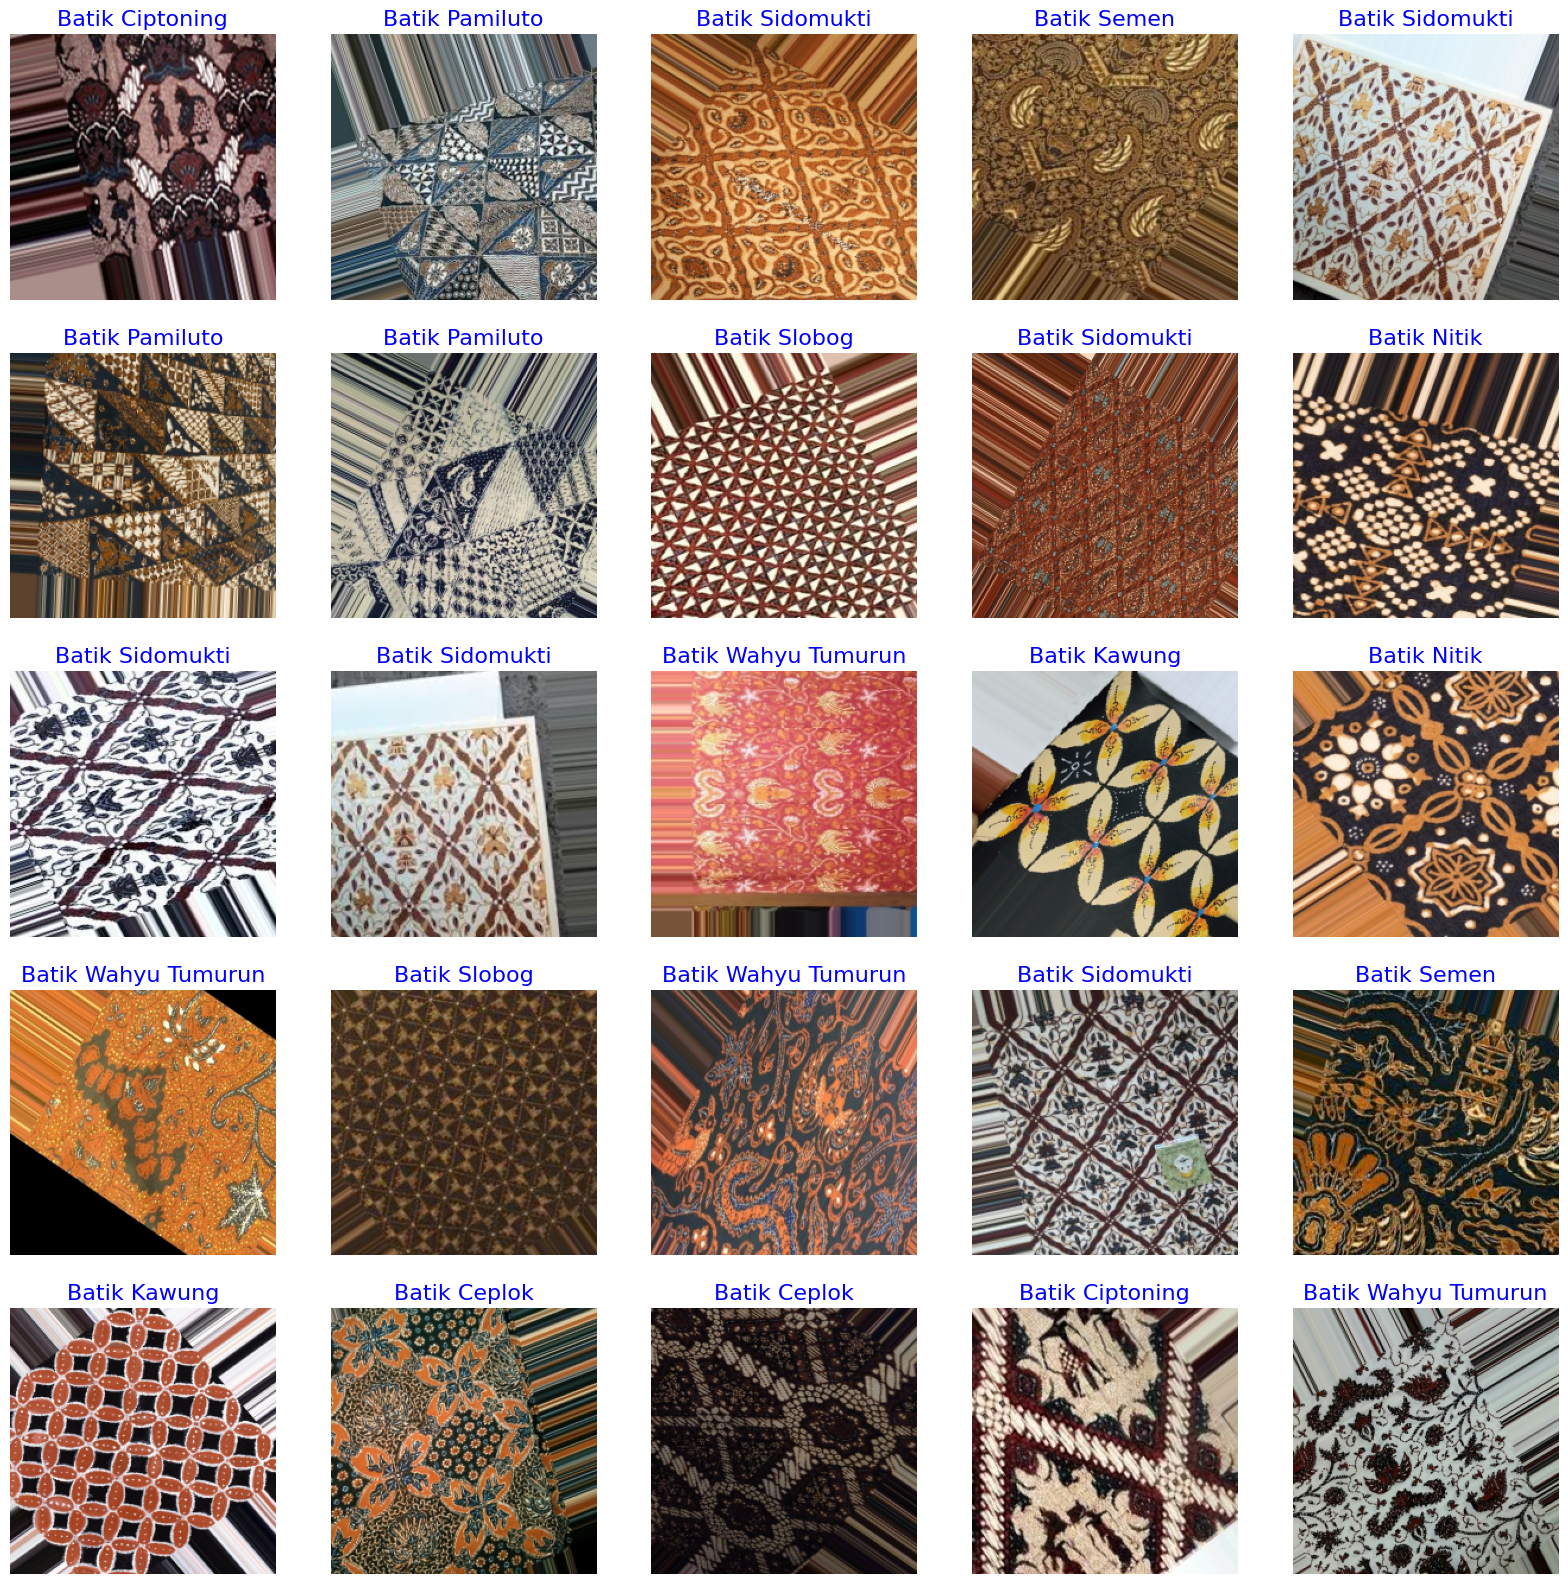

In [8]:
image_samples(train_gen)

In [9]:
#apply transfer learning Xception for image classification
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))
base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
base_model.trainable = False

In [ ]:
model_name='BatikKuy'
print("Building model with", base_model)
model = tf.keras.Sequential([
            #base_model is a transfer learning model
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x79faac7321d0>


In [11]:
# Early Stopping dan Model Checkpoint 5
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import necessary classes

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [13]:
!pip install tensorflow
import tensorflow as tf

model_name='BatikKuy'
print("Building model with", base_model)
model = tf.keras.Sequential([
            #base_model is a transfer learning model
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7d1b64116410>


In [14]:
epochs =30

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/30
25/25 [==============================] - 594s 22s/step - loss: 1.8254 - accuracy: 0.3969 - val_loss: 6.4370 - val_accuracy: 0.2300
Epoch 2/30
25/25 [==============================] - 56s 2s/step - loss: 1.0430 - accuracy: 0.6775 - val_loss: 29.1994 - val_accuracy: 0.1900
Epoch 3/30
25/25 [==============================] - 55s 2s/step - loss: 0.7370 - accuracy: 0.7875 - val_loss: 10.3333 - val_accuracy: 0.3800
Epoch 4/30
25/25 [==============================] - 56s 2s/step - loss: 0.4783 - accuracy: 0.8712 - val_loss: 4.1514 - val_accuracy: 0.3900
Epoch 5/30
25/25 [==============================] - 56s 2s/step - loss: 0.4756 - accuracy: 0.8619 - val_loss: 2.3344 - val_accuracy: 0.6750
Epoch 6/30
25/25 [==============================] - 57s 2s/step - loss: 0.4091 - accuracy: 0.8894 - val_loss: 2.2157 - val_accuracy: 0.7000
Epoch 7/30
25/25 [==============================] - 56s 2s/step - loss: 0.3907 - accuracy: 0.9087 - val_loss: 2.6572 - val_accuracy: 0.5700
Epoch 8/30
25/25

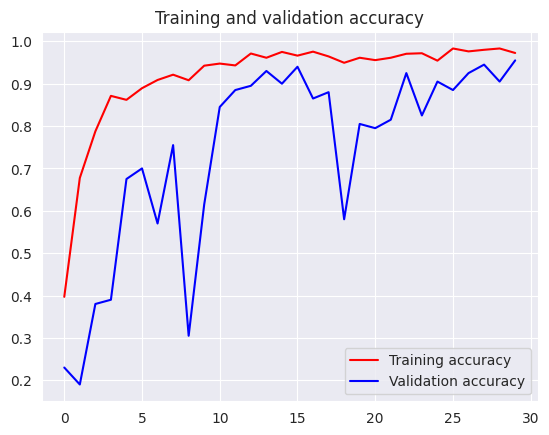

<Figure size 640x480 with 0 Axes>

In [15]:

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

2/2 [==============================] - 4s 16ms/step
Accuracy: 0.96875
Precision: 0.9744318181818182
Recall: 0.96875
F1 Score: 0.9691105769230769


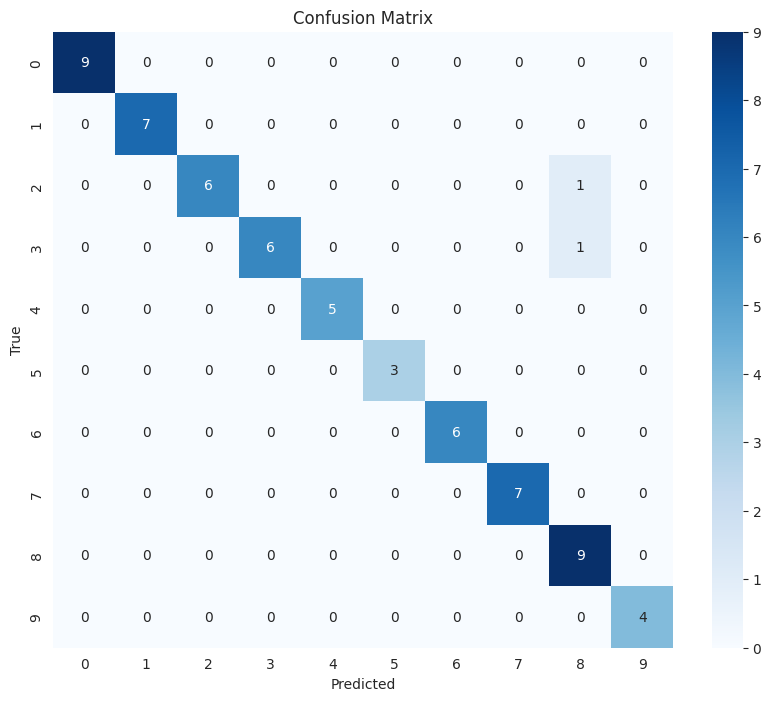

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is the trained model and you have your validation data in 'valid_gen'
# Extract validation data from the generator
x_val, y_val = next(iter(valid_gen)) # Added this line to get x_val and y_val from valid_gen

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 176ms/step
Accuracy: 0.90625
Precision: 0.9291852678571428
Recall: 0.90625
F1 Score: 0.9061576954499748


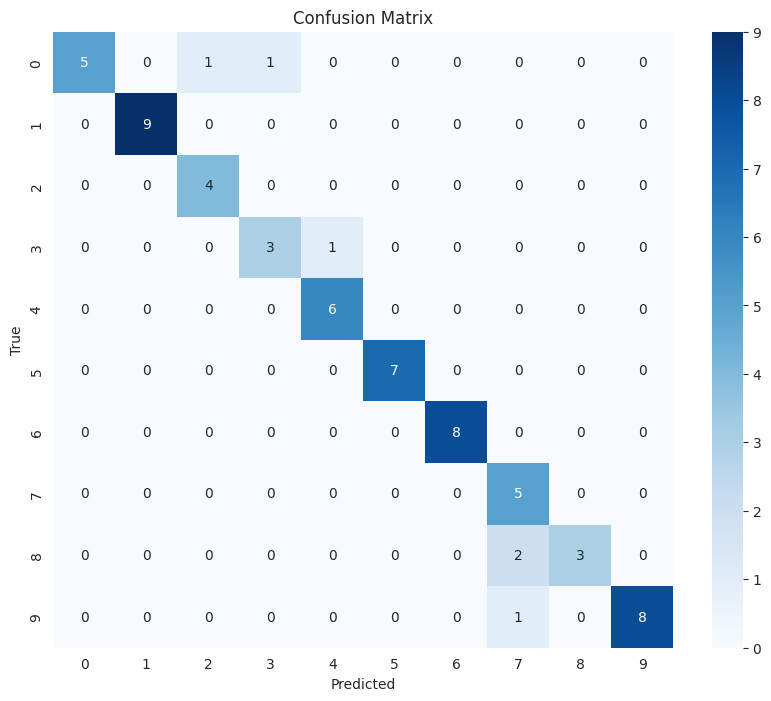

precision    recall  f1-score   support
0              1.000000  0.714286  0.833333   7.00000
1              1.000000  1.000000  1.000000   9.00000
2              0.800000  1.000000  0.888889   4.00000
3              0.750000  0.750000  0.750000   4.00000
4              0.857143  1.000000  0.923077   6.00000
5              1.000000  1.000000  1.000000   7.00000
6              1.000000  1.000000  1.000000   8.00000
7              0.625000  1.000000  0.769231   5.00000
8              1.000000  0.600000  0.750000   5.00000
9              1.000000  0.888889  0.941176   9.00000
accuracy       0.906250  0.906250  0.906250   0.90625
macro avg      0.903214  0.895317  0.885571  64.00000
weighted avg   0.929185  0.906250  0.906158  64.00000

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # Added classification_report import
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Added pandas import

# Assuming 'model' is the trained model and you have your validation data in 'valid_gen'
# Extract validation data from the generator
x_val, y_val = next(iter(valid_gen)) # Added this line to get x_val and y_val from valid_gen

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred_classes, output_dict=True) # Changed y_test to y_true and pred to y_pred_classes
df = pd.DataFrame(report).transpose()
df

In [22]:




uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  i = load_img(path, target_size=(224, 224))
  i = img_to_array(i)/255.0
  i=i.reshape(1, 224,224,3)
  p=model.predict(i)
  predicted_class_index = np.argmax(p[0])


  print(fn)
  print(predicted_class_index)

Saving kawung (1).jpeg to kawung (1).jpeg
1/1 [==============================] - 2s 2s/step
kawung (1).jpeg
2


In [23]:
model.save('modelxception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from google.colab import drive
from tensorflow.keras.models import load_model

# Hubungkan ke Google Drive
drive.mount('/content/drive')

# Misalkan `model` adalah model yang telah dilatih
model.save('/content/drive/MyDrive/my_modelxception.h5')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
